In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import requests
from bs4 import BeautifulSoup
import csv

In [2]:
def scrape_stock_info(stock_symbol):
    url = f"https://finance.yahoo.com/quote/{stock_symbol}"

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        price_element = soup.find('fin-streamer', class_='Fw(b) Fz(36px) Mb(-4px) D(ib)')
        price = price_element.text.strip() if price_element else None

        name_element = soup.find('h1', class_='D(ib) Fz(18px)')
        name = name_element.text.strip() if name_element else None

        return {'Stock Name': name, 'Stock Price': price}
    else:
        print(f"Error: Failed to retrieve webpage for stock symbol {stock_symbol}")
        return None

In [3]:
def save_to_csv(data, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data.keys())
        writer.writeheader()
        writer.writerow(data)

In [7]:
symbol = str(input("Enter the stock symbol(): "))
symbols = (symbol.upper()).split(" ")
for s in symbols:
    stock_data = scrape_stock_info(s)
    if stock_data:
        save_to_csv(stock_data, f"{s}_data.csv")
        print(f"Stock information for {s} has been saved to {s}_data.csv")
    else:
        print(f"There is no stock information for {s}")

Enter the stock symbol(): tsla aapl
Stock information for TSLA has been saved to TSLA_data.csv
Stock information for AAPL has been saved to AAPL_data.csv


In [8]:
symbol = str(input("Enter stock symbol"))
period1 = int(time.mktime(datetime.datetime(1971, 2, 5, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime.today().timetuple()))
interval = '1d'

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

Enter stock symbolTSLA


In [9]:
df = pd.read_csv(query_string)
# print(df)
df.to_csv(f'{symbol}.csv')

In [10]:
df = pd.read_csv(f"{symbol}.csv")
del df["Unnamed: 0"]
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3461,2024-04-01,176.169998,176.750000,170.210007,175.220001,175.220001,81562100
3462,2024-04-02,164.750000,167.690002,163.429993,166.630005,166.630005,116650600
3463,2024-04-03,164.020004,168.820007,163.279999,168.380005,168.380005,82578000
3464,2024-04-04,170.070007,177.190002,168.009995,171.110001,171.110001,123162000


<Axes: xlabel='Date'>

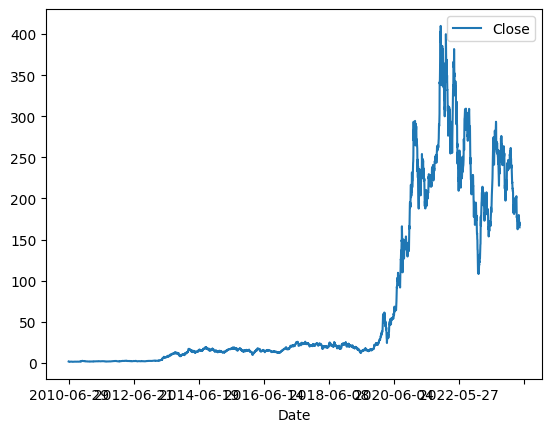

In [11]:
df.plot.line(x = "Date", y = "Close")

In [12]:
del df["Adj Close"]
df["Target-3"] = df["Close"].shift(3)
df["Target-2"] = df["Close"].shift(2)
df["Target-1"] = df["Close"].shift(1)
df["Target"] = ((df["Close"] - df["Open"]) > 0).astype(int)
df.set_index('Date', inplace = True)
df = df.dropna()

In [ ]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = df.rolling(horizon).mean()

  ratio = f"Close_Ratio_{horizon}"
  df[ratio] = df["Close"] / rolling_averages["Close"]

  trend = f"Trend_Ratio"
  df[trend] = df.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio, trend]

In [14]:
df = df.dropna()
df

,Open,High,Low,Close,Volume,Target-3,Target-2,Target-1,Target,Close_Ratio_2,Trend_Ratio,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250,Close_Ratio_1000
Date,,,,,,,,,,,,,,,
2014-06-24,15.931333,16.125334,15.442000,15.500000,121138500,15.186000,15.306000,15.814667,0,0.989951,480.0,1.007174,1.121665,1.320951,3.404815
2014-06-25,15.536667,15.836667,15.349333,15.792667,87024000,15.306000,15.814667,15.500000,1,1.009353,480.0,1.017577,1.140236,1.342000,3.457924
2014-06-26,15.811333,16.026667,15.614000,15.706667,76821000,15.814667,15.500000,15.792667,0,0.997270,481.0,1.005291,1.132335,1.330824,3.428094
2014-06-27,15.646000,16.000000,15.633333,15.937333,84525000,15.500000,15.792667,15.706667,1,1.007289,481.0,1.011877,1.148158,1.346660,3.467259
2014-06-30,15.970000,16.299334,15.933333,16.004000,72429000,15.792667,15.706667,15.937333,1,1.002087,481.0,1.013673,1.151609,1.348579,3.470555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,176.169998,176.750000,170.210007,175.220001,81562100,177.669998,179.830002,175.789993,0,0.998376,502.0,0.994280,0.905825,0.787205,0.797534
2024-04-02,164.750000,167.690002,163.429993,166.630005,116650600,179.830002,175.789993,175.220001,1,0.974872,502.0,0.952019,0.866743,0.748992,0.757993
2024-04-03,164.020004,168.820007,163.279999,168.380005,82578000,175.789993,175.220001,166.630005,1,1.005224,502.0,0.972339,0.881125,0.757188,0.765518


In [15]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1] # Predict_proba returns the probability of it being a 1 or 0
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index = test.index, name = "Predictions")
  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

In [16]:
def backtesting(data, model, predictors, start = 1250, step = 250):
  all_preds = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    all = predict(train, test, predictors, model)
    all_preds.append(all)

  return pd.concat(all_preds)

In [17]:
RFC_model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [18]:
predictions = backtesting(df, RFC_model, new_predictors)

In [19]:
predictions["Predictions"].value_counts()

Predictions
0.0    770
1.0    443
Name: count, dtype: int64

In [20]:
predictions

,Target,Predictions
Date,,
2019-06-12,0,0.0
2019-06-13,1,1.0
2019-06-14,1,1.0
2019-06-17,1,1.0
2019-06-18,0,0.0
...,...,...
2024-04-01,0,0.0
2024-04-02,1,0.0
2024-04-03,1,1.0


In [21]:
print(classification_report(predictions["Target"], predictions["Predictions"]))

              precision    recall  f1-score   support

           0       0.69      0.89      0.77       593
           1       0.85      0.61      0.71       620

    accuracy                           0.75      1213
   macro avg       0.77      0.75      0.74      1213
weighted avg       0.77      0.75      0.74      1213



In [22]:
tomorrow_data = df.iloc[[-1]]
tomorrow_prediction = RFC_model.predict(tomorrow_data[new_predictors])
if tomorrow_prediction == 1:
    print("Tomorrow's price is predicted to go up.")
else:
    print("Tomorrow's price is predicted to go down.")

Tomorrow's price is predicted to go down.
